In [105]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import LombScargle
from gatspy.periodic import LombScargleFast
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
from operator import add
import scipy.optimize as optimization
from scipy import stats
from sqlite3 import *
import random

In [2]:
#conn = connect('minion_1016_sqlite.db')
conn = connect('astro_lsst_01_1004_sqlite.db')

In [3]:
# LSST zero points  u,g,r,i,z,y
zeroPoints = [0,26.5,28.3,28.13,27.79,27.4,26.58]
FWHMeff = [0.8,0.92,0.87,0.83,0.80,0.78,0.76] # arcmins?
pixelScale = 0.2
readOut = 12.7
sigSys = 0.005

In [4]:
def magUncertainy(Filter, objectmag, exposuretime,background, FWHM): # b is background counts per pixel   
    countsPS = 10**((Filter-objectmag)/2.5)
    counts = countsPS * exposuretime
    uncertainty = 1/(counts/((counts/2.3)+(((background/2.3)+(12.7**2))*2.266*((FWHM/0.2)**2)))**0.5) # gain assumed to be 1
    return uncertainty

In [5]:
magUncertainy(zeroPoints[0],20,30,100,FWHMeff[0])   

287210299.76535374

In [6]:
def findObservations(fields): #fields are array in the format [(630,), (631,)] etc
    global obs, allobs, uobs, gobs, robs, iobs, zobs, yobs
    x2 = fields # field containing gx 339-4
    L = [0]*len(x2)
    z = 0
    c = conn.cursor()
    #t = [('357',),('356',)]
    for z in range(0,len(x2)):
        i = x2[z]    
        #c.execute('SELECT expMJD, Field_fieldID, filter FROM ObsHistory WHERE Field_fieldID = ?',i)
        #k = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE Field_fieldID = ?', i)
        allobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "u" AND Field_fieldID = ?', i)
        uobs= c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "g" AND Field_fieldID = ?', i)
        gobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "r" AND Field_fieldID = ?', i)
        robs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "i" AND Field_fieldID = ?', i)
        iobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "z" AND Field_fieldID = ?', i)
        zobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "y" AND Field_fieldID = ?', i)
        yobs = c.fetchall()
        
    obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
        

In [7]:
def addsecondExposure():
    #global obs, allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2
    #obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
    allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2 = [], [], [], [], [], [], []
    
    obs2 = [allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2]
    for x in range(0, len(obs)):
        obs2[x] = [t + (17./(3600*24)) for t in obs[x]]
    for x in range(0, len(obs)):
        obs[x].extend(obs2[x])
    for x in range(0, len(obs)):
        obs[x] = sorted(obs[x])
    # creates observation 17 seconds after first

In [8]:
def averageFlux(observations, Frequency, exptime):
    b = [0]*len(observations)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency*0.01))*(x-observations[0]+(seconds*(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/exptime for z in b]
    return c

In [9]:
def flaring(B, length, frequency=0, amplitude=1):   
    global flareMag
    np.linspace(0,np.log(8),length)
    fouriers = np.linspace(1,3000,length)
    logF = [np.log(x) for x in fouriers]
    real = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    #imaginary = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    IFT = np.fft.ifft(real)
    seconds = np.linspace(0,length, length)
    minutes = [x for x in seconds]
    plt.show()
    minimum = (np.max(-IFT))
    positive = [x + minimum for x in IFT]
    normalised = [x/(np.mean(positive)) for x in positive]
    flareMag = [amplitude * x for x in normalised]
    return flareMag

In [10]:
def confidenceLevel(numsteps): # no sigma clipping?
    position = min(range(len(periods)), key=lambda i: abs(periods[i]-LSperiod))
    if position > numsteps:
        sigma = np.std(power[(position-numsteps):(position+numsteps)])
        mean = np.mean(power[(position-numsteps):(position+numsteps)])
    else:
        sigma = np.std(power[0:(position+numsteps)])
        mean = np.mean(power[0:(position+numsteps)])
    confidence = mean + (5*sigma)
    return confidence

In [39]:
def realconfidenceLevel(numsteps): # no sigma clipping? real as in no imaginaries
    position = min(range(len(periods)), key=lambda i: abs(periods[i]-LSperiod))
    linepower = power
    linepower[position] = linepower[position-1]
    conjugatePower = [np.conjugate(f) for f in linepower]
    realpower = [(a*b)**0.5 for a,b in zip(power,conjugatePower)]
    
    if position > numsteps:
        sigma = np.std(realpower[(position-numsteps):(position+numsteps)])
        mean = np.mean(realpower[(position-numsteps):(position+numsteps)])
    else:
        sigma = np.std(realpower[0:(position+numsteps)])
        mean = np.mean(realpower[0:(position+numsteps)])
    confidence = mean + (5*sigma)
    return confidence

In [28]:
print(np.conjugate(power[0]))
print(power[0])
conj = np.conjugate(power[0])
print((conj*power[0])**0.5)

(0.109337391536-0.00291065517341j)
(0.109337391536+0.00291065517341j)
(0.109376126743+0j)


In [57]:
def lombScargle(frequencyRange, objectmag, modulationAmplitude=0.1, background=40,Nquist=200,numsteps=20000): # frequency range and object mag in list
    global actualperiod, measuredperiod, measuredpower, date, amplitude, frequency, periods, LSperiod, power, error
    actualperiod = []
    measuredperiod = []
    measuredpower = [] # reset
    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]]
        
        for z in range(1,len(y)):    
            for G in range(0, len(y[z])):
                flareMinute = int((obs[z][G]*24*60)%(1024))
                y[z][G] = y[z][G] + flareMag[flareMinute]
                
        for z in range(3,4):#(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            
            amplitude = [t+random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise

            mag = [t + objectmag[z] for t in amplitude]
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
            
            model = LombScargleFast().fit(date, mag, error)
            periods, power = model.periodogram_auto(nyquist_factor=Nquist)

            model.optimizer.period_range=(0.01, 10)
            LSperiod = model.best_period
            fiveSig = realconfidenceLevel(numsteps)
            fig, ax = plt.subplots()
            ax.plot(periods, power)
            plt.plot([0,10],[fiveSig,fiveSig])
            ax.set(xlim=(0, 10), ylim=(0, 1.2),
                   xlabel='period (days)',
                   ylabel='Lomb-Scargle Power');
            plt.show()
            
            
            
            #maxpos = [i for i, j in enumerate(power) if j == power.max()]
            #LSperiod = (periods[maxpos])
            period = 100./(frequencyRange[frange])
            phase = [(day.value % (period*2))/(period*2) for day in date]

            plt.plot(phase, mag, 'o')
            plt.xlabel('Phase')
            plt.ylabel('Magnitude')
            plt.show()
            print('actualperiod', period, 'measured period', np.mean(LSperiod)),# 'power',np.mean(power[maxpos]))
            print(frequencyRange[frange])
        actualperiod.append(1/(frequencyRange[frange]*0.01))
        measuredperiod.append(period)
        measuredpower.append(power.max())

In [12]:
findObservations([(630,)])
#addsecondExposure()
averageFlux(obs[0], 1, 30)
flaring(-1, 10024, amplitude=0.1)

[(0.13094302934292604+0.018951097548705942j),
 (0.093522897403591876-0.023758323562794659j),
 (0.09551840511392945+0.013881883309462627j),
 (0.107683280095718+0.033900542938040491j),
 (0.13272171422760606+0.020441134492165749j),
 (0.11660919254867015-0.0030130431450889998j),
 (0.12108766907534084+0.016237859815621477j),
 (0.12596928921741365-0.03962680228176392j),
 (0.10694467169336562+0.012906217089067674j),
 (0.12815196113319169-0.015384774601552496j),
 (0.10150155283297102+0.010175799638208275j),
 (0.14138309508720198-0.0077289823386754277j),
 (0.11283784432602098-0.012619888771893593j),
 (0.13659603965481068-0.028338608492085367j),
 (0.071414931996911984-0.068746666040913881j),
 (0.0459558818229171+0.0012258473741964438j),
 (0.094523048389912045+0.048400358642171452j),
 (0.10853002681462523+0.015511536271197677j),
 (0.11168297154159786-0.026924110903050205j),
 (0.11995316145510354+0.027173989430743218j),
 (0.11706033685964251+0.0082121606368513872j),
 (0.10393782221209101-0.0139959

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


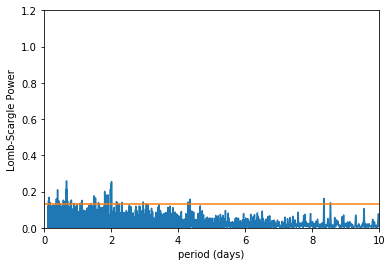

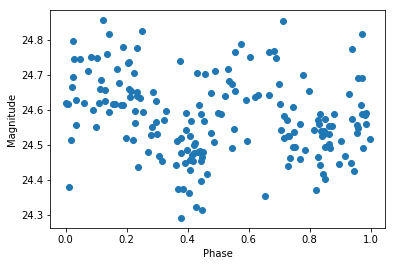

('actualperiod', 0.6666666666666666, 'measured period', 0.66667783692646509) 150


In [58]:
# actual frequency = frquency/100
lombScargle([150],([24.5]*7),Nquist=300) # 40 background corresponing to R band at new moon, could be made more detailed?

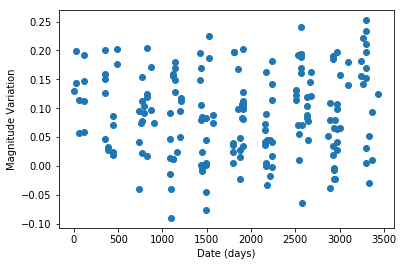

In [14]:
perfex = np.linspace(0, 3500, 3501)
#perfect = [0.1*np.sin((2*np.pi*(frange*0.01))*(x)) for x in perfex]

plt.plot(date, amplitude, 'o')
#plt.plot(perfex, perfect)
plt.ylabel('Magnitude Variation')
plt.xlabel('Date (days)')
#plt.xlim([2200, 2300])
plt.show()

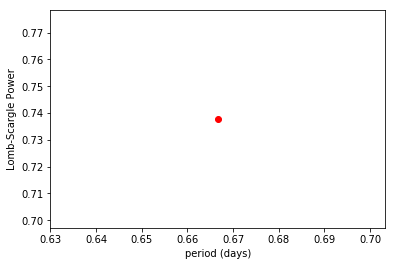

In [15]:
plt.plot(actualperiod, measuredpower)
plt.plot(measuredperiod, measuredpower, 'ro')
plt.xlabel('period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.show()

In [104]:
# P(f) = N*f**-a
#xdata = [np.log(x) for x in periods]
xdata = periods
initialGuess = np.array([1.0,1.0,1.0])

sig = [error[0]]*len(power)
sig = np.asarray(sig)
conjugatePower = [np.conjugate(f) for f in power]
realpower = [(a*b)**0.5 for a,b in zip(power,conjugatePower)]
for r in range(0,len(realpower)):
    realpower[r] = realpower[r].real
#ydata = [np.log(x) for x in realpower]
ydata = realpower
def func(f, N, a, C):
    return N*(f**-a)+C
print optimization.curve_fit(func, xdata, ydata, initialGuess)



(array([-0.00679282,  0.37578959,  0.02781064]), array([[  4.06148018e-07,   1.67807949e-05,  -3.98618475e-07],
       [  1.67807949e-05,   7.12268105e-04,  -1.61901999e-05],
       [ -3.98618475e-07,  -1.61901999e-05,   3.97549548e-07]]))


In [61]:
#error = np.asarray(error)

In [64]:
#print(len(error), len(periods), len(power))

(185, 138750, 138750)


In [110]:
a = optimization.curve_fit(func, xdata, ydata, initialGuess)

In [111]:
x = np.linspace(0,10,100)
s = [(a[0][0]*(h**(-a[0][1])))+a[0][2] for h in x]

/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [112]:
stats.kstest(s,'norm')

KstestResult(statistic=0.49468102097777944, pvalue=0.0)

In [97]:
print(a)

(array([-0.00679282,  0.37578959,  0.02781064]), array([[  4.06148018e-07,   1.67807949e-05,  -3.98618475e-07],
       [  1.67807949e-05,   7.12268105e-04,  -1.61901999e-05],
       [ -3.98618475e-07,  -1.61901999e-05,   3.97549548e-07]]))


In [98]:
print(a[0][0])

-0.00679281741911


In [99]:
x = np.linspace(0,10)
y = [(a[0][0]*((1/t)**-a[0][1]))+a[0][2] for t in x]

/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


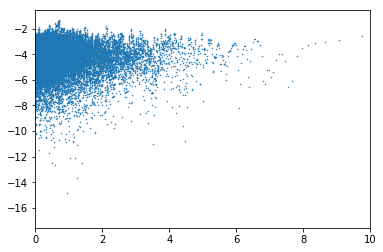

In [102]:
plt.plot(xdata,ydata,'o',markersize='0.5')
#plt.plot(x,y)
plt.xlim(0,10)
plt.show()

In [94]:
error

array([ 0.30587941,  0.30587941,  0.30587941,  0.30587941,  0.30587941,
        0.30587941,  0.30587941,  0.30587941,  0.30587941,  0.30587941,
        0.30587941,  0.30587941,  0.30587941,  0.30587941,  0.30587941,
        0.30587941,  0.30587941,  0.30587941,  0.30587941,  0.30587941,
        0.30587941,  0.30587941,  0.30587941,  0.30587941,  0.30587941,
        0.30587941,  0.30587941,  0.30587941,  0.30587941,  0.30587941,
        0.30587941,  0.30587941,  0.30587941,  0.30587941,  0.30587941,
        0.30587941,  0.30587941,  0.30587941,  0.30587941,  0.30587941,
        0.30587941,  0.30587941,  0.30587941,  0.30587941,  0.30587941,
        0.30587941,  0.30587941,  0.30587941,  0.30587941,  0.30587941,
        0.30587941,  0.30587941,  0.30587941,  0.30587941,  0.30587941,
        0.30587941,  0.30587941,  0.30587941,  0.30587941,  0.30587941,
        0.30587941,  0.30587941,  0.30587941,  0.30587941,  0.30587941,
        0.30587941,  0.30587941,  0.30587941,  0.30587941,  0.30